In [66]:
!pip install sounddevice

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/LPRNet-0.0.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [67]:
import os
import random
import numpy as np
import librosa
import pyaudio
import wave
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [68]:
class AudioPreprocessor:
    def __init__(self, sr=22050, duration=None, n_mfcc=13, n_fft=2048, 
                 hop_length=512, target_length=100, augment=True):
        """
        Initialize the audio preprocessor with given parameters.
        
        Parameters:
        -----------
        sr : int
            Sampling rate
        duration : float or None
            Duration to load in seconds
        n_mfcc : int
            Number of MFCC features
        n_fft : int
            Length of FFT window
        hop_length : int
            Number of samples between frames
        target_length : int
            Target number of frames for padding/truncation
        augment : bool
            Whether to apply augmentation
        """
        self.sr = sr
        self.duration = duration
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target_length = target_length
        self.augment = augment
        self.scaler = StandardScaler()
    
    def augment_audio(self, audio):
        """Apply various augmentation techniques to the audio."""
        augmented_audios = [audio]  # Original audio
        
        # Time stretching
        rates = [0.9, 1.1]  # 90% and 110% speed
        for rate in rates:
            augmented_audios.append(
                librosa.effects.time_stretch(audio, rate=rate)
            )
        
        # Pitch shifting
        steps = [-2, 2]  # Shift pitch up and down by 2 steps
        for step in steps:
            augmented_audios.append(
                librosa.effects.pitch_shift(audio, sr=self.sr, n_steps=step)
            )
        
        # Add noise
        noise_levels = [0.005, 0.01]
        for level in noise_levels:
            noise = np.random.normal(0, level, len(audio))
            augmented_audios.append(audio + noise)
        
        return augmented_audios

    def extract_features(self, audio):
        """Extract MFCC and additional features from audio."""
        # Apply pre-emphasis
        audio_emphasized = librosa.effects.preemphasis(audio)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=audio_emphasized, 
            sr=self.sr,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # Compute deltas
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        
        # Extract additional features
        spectral_centroid = librosa.feature.spectral_centroid(
            y=audio_emphasized, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length
        )
        spectral_rolloff = librosa.feature.spectral_rolloff(
            y=audio_emphasized, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length
        )
        
        # Combine all features
        features = np.concatenate([
            mfccs,
            delta_mfccs,
            delta2_mfccs,
            spectral_centroid,
            spectral_rolloff
        ])
        
        return features

    def pad_or_truncate(self, features):
        """Ensure consistent feature length through padding or truncation."""
        if features.shape[1] > self.target_length:
            return features[:, :self.target_length]
        else:
            pad_width = ((0, 0), (0, self.target_length - features.shape[1]))
            return np.pad(features, pad_width, mode='constant')

    def process_file(self, file_path):
        """Process a single audio file."""
        try:
            # Load audio
            audio, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
            
            if self.augment:
                augmented_audios = self.augment_audio(audio)
            else:
                augmented_audios = [audio]
            
            all_features = []
            for aug_audio in augmented_audios:
                # Extract features
                features = self.extract_features(aug_audio)
                
                # Normalize features
                features_normalized = self.scaler.fit_transform(features)
                
                # Ensure consistent length
                features_padded = self.pad_or_truncate(features_normalized)
                
                all_features.append(features_padded.T)
            
            return all_features
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def prepare_dataset(self, file_paths, labels):
        """Prepare dataset from multiple audio files."""
        features_list = []
        labels_list = []
        
        for file_path, label in zip(file_paths, labels):
            features = self.process_file(file_path)
            if features is not None:
                features_list.extend(features)
                # Add the same label for each augmented version
                labels_list.extend([label] * len(features))
        
        return np.array(features_list), np.array(labels_list)


In [69]:

# Initialize preprocessor with your desired settings
preprocessor = AudioPreprocessor(
    sr=16000,
    n_mfcc=13,
    target_length=100,
    augment=True  # Set to False if you don't want augmentation
)

# Get file paths using your directory structure
target_dir = Path("/Users/harjotsingh/Documents/Task1/dataset/target")
non_target_dir = Path("/Users/harjotsingh/Documents/Task1/dataset/nontarget")

# Prepare file paths and labels
file_paths = []
labels = []

# Add target files
for file in os.listdir(target_dir):
    if file.endswith('.wav'):  # Make sure to only process wav files
        file_paths.append(str(target_dir / file))
        labels.append(1)

# Add non-target files
for file in os.listdir(non_target_dir):
    if file.endswith('.wav'):
        file_paths.append(str(non_target_dir / file))
        labels.append(0)

# Process the dataset
X, y = preprocessor.prepare_dataset(file_paths, labels)

print(f"Dataset shape: {X.shape}")
print(f"Number of samples per class: {np.bincount(y)}")

# Split the dataset
X_train, x_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2021)


Dataset shape: (224, 100, 41)
Number of samples per class: [140  84]


In [70]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 41)),# First LSTM layer
    Bidirectional(LSTM(32)),  # Second LSTM layer
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 100, 128)       │        54,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,601 (381.25 KB)

 Trainable params: 97,601 (381.25 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (179, 100, 41)
y_train shape: (179,)
X_val shape: (45, 100, 41)
y_val shape: (45,)


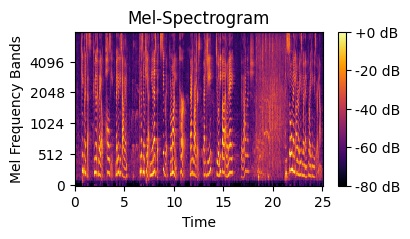

In [72]:
# Compute and display the Mel-spectrogram
signal, sr = librosa.load("dataset/target/taylor_1.wav", sr=16000)  # Load audio at 16kHz

S = librosa.feature.melspectrogram(y=signal, sr=16000)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(4, 2))
librosa.display.specshow(log_S, x_axis='time', y_axis='mel', sr=16000, cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.show()


In [73]:
callbacks = [
    EarlyStopping(monitor='accuracy', patience=2),

]

history = model.fit(
    X_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4700 - loss: 0.7029 - val_accuracy: 0.6444 - val_loss: 0.6306
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6665 - loss: 0.6168 - val_accuracy: 0.8000 - val_loss: 0.6335
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8328 - loss: 0.6007 - val_accuracy: 0.8444 - val_loss: 0.4855
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8486 - loss: 0.4546 - val_accuracy: 0.8444 - val_loss: 0.4133
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8629 - loss: 0.3615 - val_accuracy: 0.8000 - val_loss: 0.3518
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8609 - loss: 0.2994 - val_accuracy: 0.8667 - val_loss: 0.3396
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9107 - loss: 0.2799 - val_accuracy: 0.7556 - val_loss: 0.5917
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8567 - loss: 0.3461 - val_accuracy: 0.8222 - val_loss: 0.3365


In [74]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9051 - loss: 0.2975
Validation Accuracy: 88.89%


In [75]:
model.save('voice_classifier_model.keras')

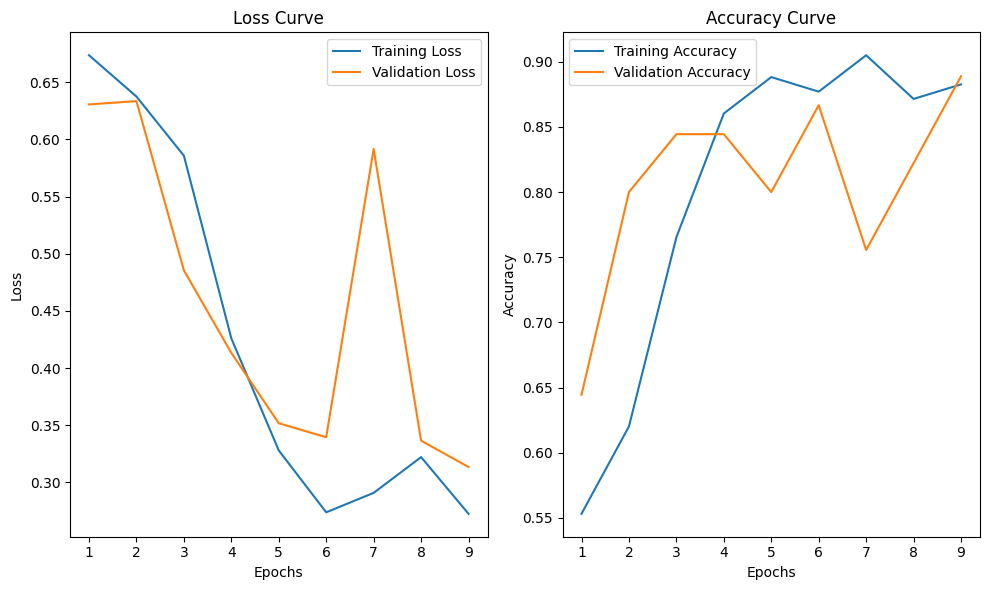

In [76]:
# Assuming you have stored the loss and accuracy during training
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [86]:
def predict_audio(model, file_path, preprocessor):
    """
    Predict the class of a single audio file.
    
    Parameters:
    - model: Trained keras model
    - file_path: Path to the audio file
    - preprocessor: AudioPreprocessor instance used for training
    
    Returns:
    - prediction: 0 (non-target) or 1 (target)
    - confidence: Prediction confidence score
    """
    try:
        # Process the audio file using the same preprocessing pipeline
        features = preprocessor.process_file(file_path)
        
        if features is None or len(features) == 0:
            print(f"Error processing file: {file_path}")
            return None, None
        
        # Use only the original features (not augmented) for prediction
        features = features[0].reshape(1, *features[0].shape)
        
        # Get prediction probability
        pred_prob = model.predict(features, verbose=0)[0][0]
        
        # Convert to class and get confidence
        prediction = 1 if pred_prob >= 0.3 else 0
        confidence = pred_prob if prediction == 1 else 1 - pred_prob
        
        return prediction, confidence
        
    except Exception as e:
        print(f"Error predicting file {file_path}: {str(e)}")
        return None, None

def process_test_folder(folder_path, model, preprocessor, threshold=0.5):
    """
    Process all audio files in a test folder.
    
    Parameters:
    - folder_path: Path to the test folder
    - model: Trained keras model
    - preprocessor: AudioPreprocessor instance used for training
    - threshold: Confidence threshold for accepting predictions
    
    Returns:
    - results: Dictionary containing predictions and confidences
    """
    predicted=[]
    actual = []
    results = {}

    for file_name in os.listdir(folder_path):
        if not file_name.endswith('.wav'):
            continue
            
        file_path = os.path.join(folder_path, file_name)
        
        is_target = 0 if "non" in file_name.lower() else 1
        actual.append(is_target)
        # Get prediction and confidence
        prediction, confidence = predict_audio(model, file_path, preprocessor)

        if prediction is not None:
            result = {
                'prediction': 'target' if prediction == 1 else 'non-target',
                'confidence': float(confidence),
                'accepted': confidence >= threshold
            }
            results[file_name] = result
            predicted.append(1 if prediction == 1 else 0)
            # confidence_value = confidence if result['prediction'] == "non-target" else  - confidence.value
            print(f"File: {file_name:<30} "
                f"Prediction: {result['prediction']:<10} "
            )

            
    return results,predicted,actual

# Example usage:
def run_predictions(model_path, test_folder_path, confidence_threshold=0.5):
    """
    Run predictions on a test folder using a saved model.
    """
    # Initialize preprocessor with the same settings used for training
    preprocessor = AudioPreprocessor(
        sr=22050,
        n_mfcc=13,
        target_length=100,
        augment=False  # Don't use augmentation for prediction
    )
    
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    
    # Process the test folder
    print("\nProcessing test files...")
    print("-" * 70)
    results,predicted,actual = process_test_folder(
        test_folder_path, 
        model, 
        preprocessor,
        threshold=confidence_threshold
    )
    
    return results,predicted,actual



In [87]:
summary,predicted,actual = run_predictions(
    model_path='voice_classifier_model.keras',
    test_folder_path="/Users/harjotsingh/Documents/Task1/dataset/test",
    confidence_threshold=0.2
)


Processing test files...
----------------------------------------------------------------------
File: nontarget_jobiden.wav          Prediction: non-target 
File: nontarget_amitabh.wav          Prediction: non-target 
File: nontarget_male.wav             Prediction: non-target 
File: target_taylor.wav              Prediction: target     
File: target_taylor_2.wav            Prediction: target     
File: target_taylor_1.wav            Prediction: non-target 
File: nontarget_elon.wav             Prediction: non-target 
File: nontarget_female.wav           Prediction: non-target 


In [89]:
print("F1 Score:",f1_score(actual,predicted))
print("Accuracy:",accuracy_score(actual,predicted))

F1 Score: 0.8
Accuracy: 0.875


In [101]:
import sounddevice as sd
from scipy.io.wavfile import write
import numpy as np
import os

def record_audio(file_path, duration=5, sample_rate=22050):
    """
    Records audio from the microphone and saves it as a .wav file.

    Parameters:
    - file_path: Path to save the recorded audio.
    - duration: Duration of the recording in seconds.
    - sample_rate: Sampling rate for the recording.
    """
    print("Recording...")
    try:
        audio_data = sd.rec(
            int(duration * sample_rate), 
            samplerate=sample_rate, 
            channels=1, 
            dtype=np.float32
        )
        sd.wait()  # Wait until recording is finished
        write(file_path, sample_rate, audio_data)  # Save as .wav file
        print(f"Recording saved to: {file_path}")
    except Exception as e:
        print(f"Error recording audio: {str(e)}")

def listen_and_classify(model, preprocessor, temp_file_path="temp_audio.wav", duration=5):
    """
    Records real-time audio, processes it, and classifies it using the model.

    Parameters:
    - model: Trained keras model.
    - preprocessor: AudioPreprocessor instance used for training.
    - temp_file_path: Path to save the temporary audio file.
    - duration: Duration of the recording in seconds.
    """
    # Record audio
    record_audio(temp_file_path, duration=duration)
    
    # Predict using the model
    prediction, confidence = predict_audio(model, temp_file_path, preprocessor)
    
    if prediction is not None:
        if prediction == 1:
            print(f"\nPrediction: Target")
            print(f"Confidence: {confidence:.2%} (Target), {1 - confidence:.2%} (Non-Target)")
        else:
            print(f"\nPrediction: Non-Target")
            print(f"Confidence: {confidence:.2%} (Non-Target), {1 - confidence:.2%} (Target)")
    else:
        print("Could not classify the audio.")


    # Optionally remove the temp file
    if os.path.exists(temp_file_path):
        os.remove(temp_file_path)

In [104]:
listen_and_classify(model, preprocessor, duration=5)
#live sample was taylor's

Recording...
Recording saved to: temp_audio.wav

Prediction: Target
Confidence: 56.87% (Target), 43.13% (Non-Target)


In [105]:
listen_and_classify(model, preprocessor, duration=5)(model, preprocessor, duration=5)
#live sample was non target (me yapping)

Recording...
Recording saved to: temp_audio.wav

Prediction: Non-Target
Confidence: 95.26% (Non-Target), 4.74% (Target)
